In [24]:
from transformers import AdamW, T5ForConditionalGeneration, T5Tokenizer, Trainer, TrainingArguments, get_scheduler
from datasets import load_dataset, load_metric
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import gc
from tqdm.auto import tqdm
import random
from copy import deepcopy
import matplotlib.pyplot as plt

In [60]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small')

In [61]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
device

device(type='cuda')

In [62]:
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Dro

In [5]:
torch.cuda.memory_allocated(device=device)

242026496

In [6]:
squad_raw = load_dataset('squad')
squad_raw

Reusing dataset squad (C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453)


DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

In [7]:
def preprocess_squad(examples):
    return {'id': examples['id'],
            'src':
                ['question: ' + question + ' context: ' + context
                 for question, context in zip(examples['question'], examples['context'])
                ],
            'trg': [answer['text'][0] for answer in examples['answers']],
            'answers': examples['answers']
           }

In [8]:
squad = squad_raw.map(preprocess_squad, batched=True, remove_columns=squad_raw['train'].column_names)

Loading cached processed dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-961250d0cdb39e2a.arrow
Loading cached processed dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-e448ae214532babe.arrow


In [9]:
squad['validation']

Dataset({
    features: ['answers', 'id', 'src', 'trg'],
    num_rows: 10570
})

In [10]:
squad_metric = load_metric("squad")

In [11]:
def eval_squad(model, n):
    progress_bar = tqdm(range(n))
    shuffled = squad.shuffle()
    model.eval()
    b_size = 8
    start = 0
    end = b_size
    exists = True
    model.eval()
    while exists:
        examples = shuffled['validation'][start: end]
        input_ids = tokenizer(examples['src'], return_tensors="pt", padding=True).input_ids.to(device)
        with torch.no_grad():
            outputs = model.generate(input_ids=input_ids)

        decoded = [{'id': ide, 'prediction_text': tokenizer.decode(outputs[i], skip_special_tokens=True)} for i, ide in zip(range(len(examples['id'])), examples['id'])]
        refs = [{'id': examples['id'][i], 'answers': ans} for i, ans in enumerate(examples['answers'])]
        squad_metric.add_batch(predictions=decoded, references=refs)
        progress_bar.update(len(examples['id']))
        start = end
        end = end + b_size
        del input_ids
        del outputs
        if end > n:
            break

    return squad_metric.compute()

In [ ]:
eval_squad(model, 512)

In [12]:
raw_paraphrases = load_dataset('paws', 'labeled_final')

Reusing dataset paws (C:\Users\Pranav\.cache\huggingface\datasets\paws\labeled_final\1.1.0\09d8fae989bb569009a8f5b879ccf2924d3e5cd55bfe2e89e6dab1c0b50ecd34)


In [13]:
paraphrases = raw_paraphrases.filter(lambda example: example['label'] == 1)
paraphrases

Loading cached processed dataset at C:\Users\Pranav\.cache\huggingface\datasets\paws\labeled_final\1.1.0\09d8fae989bb569009a8f5b879ccf2924d3e5cd55bfe2e89e6dab1c0b50ecd34\cache-f8f4b05c63816056.arrow
Loading cached processed dataset at C:\Users\Pranav\.cache\huggingface\datasets\paws\labeled_final\1.1.0\09d8fae989bb569009a8f5b879ccf2924d3e5cd55bfe2e89e6dab1c0b50ecd34\cache-9bfc9aaee2aa1e33.arrow
Loading cached processed dataset at C:\Users\Pranav\.cache\huggingface\datasets\paws\labeled_final\1.1.0\09d8fae989bb569009a8f5b879ccf2924d3e5cd55bfe2e89e6dab1c0b50ecd34\cache-274702c64a43f78c.arrow


DatasetDict({
    train: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label'],
        num_rows: 21829
    })
    test: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label'],
        num_rows: 3536
    })
    validation: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label'],
        num_rows: 3539
    })
})

In [14]:
def insert_task_name(examples):
    return {
        'sentence1': ['paraphrase: ' + example for example in examples['sentence1']] + ['paraphrase: ' + example for example in examples['sentence2']],
        'sentence2': [example for example in examples['sentence2']] + [example for example in examples['sentence1']]
    }

In [15]:
paraphrases = paraphrases.map(insert_task_name, batched=True, remove_columns=paraphrases['train'].column_names)

Loading cached processed dataset at C:\Users\Pranav\.cache\huggingface\datasets\paws\labeled_final\1.1.0\09d8fae989bb569009a8f5b879ccf2924d3e5cd55bfe2e89e6dab1c0b50ecd34\cache-37d241fc255f3358.arrow
Loading cached processed dataset at C:\Users\Pranav\.cache\huggingface\datasets\paws\labeled_final\1.1.0\09d8fae989bb569009a8f5b879ccf2924d3e5cd55bfe2e89e6dab1c0b50ecd34\cache-60b05b6bb815b979.arrow
Loading cached processed dataset at C:\Users\Pranav\.cache\huggingface\datasets\paws\labeled_final\1.1.0\09d8fae989bb569009a8f5b879ccf2924d3e5cd55bfe2e89e6dab1c0b50ecd34\cache-8f7ea547eff87668.arrow


In [16]:
paraphrases['train'][0], paraphrases['train'][1]

({'sentence1': 'paraphrase: The NBA season of 1975 -- 76 was the 30th season of the National Basketball Association .',
  'sentence2': 'The 1975 -- 76 season of the National Basketball Association was the 30th season of the NBA .'},
 {'sentence1': 'paraphrase: When comparable rates of flow can be maintained , the results are high .',
  'sentence2': 'The results are high when comparable flow rates can be maintained .'})

In [17]:
train_loader = DataLoader(paraphrases['train'], shuffle=True, batch_size=8)
eval_loader = DataLoader(paraphrases['validation'], batch_size=8)

In [18]:
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

In [20]:
normal_train = []

In [21]:
%load_ext line_profiler
def train():
    progress_bar = tqdm(range(num_training_steps))

    model.train()
    for epoch in range(num_epochs):
        for i, batch in enumerate(train_loader):
            
            if i%1000 == 0:
                normal_train.append(eval_squad(model, 512))
                
            input_ids = tokenizer(batch['sentence1'], return_tensors="pt", padding=True).input_ids.to(device)
            labels = tokenizer(batch['sentence2'], return_tensors="pt", padding=True).input_ids.to(device)
            outputs = model(input_ids=input_ids, labels=labels)
            outputs.loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            del input_ids
            del labels
            del outputs
                
            progress_bar.update(1)

In [22]:
%lprun -f train train()

Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-337b4f75e9113776.arrow
Token indices sequence length is longer than the specified maximum sequence length for this model (671 > 512). Running this sequence through the model will result in indexing errors


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-04bd00d274eae646.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-c577197324b1239e.arrow
Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-04bd00d274eae646.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-c577197324b1239e.arrow
Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-04bd00d274eae646.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-c577197324b1239e.arrow
Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-04bd00d274eae646.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-c577197324b1239e.arrow
Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-04bd00d274eae646.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-c577197324b1239e.arrow
Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-04bd00d274eae646.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-c577197324b1239e.arrow
Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-04bd00d274eae646.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-c577197324b1239e.arrow
Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-04bd00d274eae646.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-c577197324b1239e.arrow
Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-04bd00d274eae646.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-c577197324b1239e.arrow
Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-04bd00d274eae646.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-c577197324b1239e.arrow
Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-04bd00d274eae646.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-c577197324b1239e.arrow
Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-04bd00d274eae646.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-c577197324b1239e.arrow
Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-04bd00d274eae646.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-c577197324b1239e.arrow
Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-04bd00d274eae646.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-c577197324b1239e.arrow
Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-04bd00d274eae646.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-c577197324b1239e.arrow
Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-04bd00d274eae646.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-c577197324b1239e.arrow
Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-04bd00d274eae646.arrow


In [26]:
normal_train

[{'exact_match': 76.953125, 'f1': 85.00552764617947},
 {'exact_match': 76.3671875, 'f1': 84.95569415773981},
 {'exact_match': 75.5859375, 'f1': 84.21803970426504},
 {'exact_match': 74.609375, 'f1': 83.58450253906669},
 {'exact_match': 73.828125, 'f1': 82.6346099284434},
 {'exact_match': 74.0234375, 'f1': 82.91652527871813},
 {'exact_match': 73.6328125, 'f1': 82.31278236109654},
 {'exact_match': 73.828125, 'f1': 82.54910662200717},
 {'exact_match': 74.8046875, 'f1': 83.16848481836148},
 {'exact_match': 73.6328125, 'f1': 82.50624774987442},
 {'exact_match': 73.2421875, 'f1': 82.52079834174579},
 {'exact_match': 72.8515625, 'f1': 82.24084849090897},
 {'exact_match': 74.21875, 'f1': 82.98839751051682},
 {'exact_match': 74.21875, 'f1': 83.22950369888865},
 {'exact_match': 74.21875, 'f1': 83.02210042507912},
 {'exact_match': 73.6328125, 'f1': 82.85282959174577},
 {'exact_match': 74.0234375, 'f1': 83.03512125841246},
 {'exact_match': 73.2421875, 'f1': 82.70091986952357}]

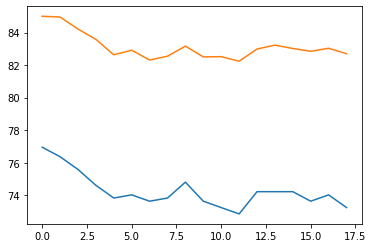

In [28]:
plt.plot([entry['exact_match'] for entry in normal_train])
plt.plot([entry['f1'] for entry in normal_train])

In [29]:
class EWC:
    def __init__(self, model: nn.Module, dataset: list):

        self.model = model
        self.dataset = dataset

        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}
        self._means = {}
        self._precision_matrices = self._diag_fisher()

        for n, p in deepcopy(self.params).items():
            self._means[n] = p.data.clone().detach().requires_grad_(True)

    def _diag_fisher(self):
        precision_matrices = {}
        for n, p in deepcopy(self.params).items():
            p.data.zero_()
            precision_matrices[n] = p.data.clone().detach().requires_grad_(True)
        
        self.model.eval()
        for src, trg in self.dataset:
            self.model.zero_grad()
            input_ids = tokenizer(src, return_tensors="pt", padding=True).input_ids.to(device)
            labels = tokenizer(trg, return_tensors="pt", padding=True).input_ids.to(device)
            output = self.model(input_ids=input_ids, labels=labels).logits
            loss = F.nll_loss(F.log_softmax(output, dim=2).squeeze(), labels.squeeze())
            loss.backward()
            del input_ids
            del labels
            del output

            for n, p in self.model.named_parameters():
                precision_matrices[n].data += p.grad.data ** 2 / len(self.dataset)

        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            _loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
            loss += _loss.sum()
        return loss

In [63]:
ewc_history = []

In [64]:
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

In [65]:
%load_ext line_profiler
def ewc_train():
    progress_bar = tqdm(range(num_training_steps))
    
    samples = random.sample(list(zip(squad['train']['src'], squad['train']['trg'])), 100)
    ewc = EWC(model, samples)
    for epoch in range(num_epochs):
        for i, batch in enumerate(train_loader):
            
            if i%1000 == 0:
                ewc_history.append(eval_squad(model, 512))
                model.train()
                
            input_ids = tokenizer(batch['sentence1'], return_tensors="pt", padding=True).input_ids.to(device)
            labels = tokenizer(batch['sentence2'], return_tensors="pt", padding=True).input_ids.to(device)
            outputs = model(input_ids=input_ids, labels=labels)
            ewc_loss = outputs.loss + 1000 * ewc.penalty(model)
            ewc_loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            del input_ids
            del labels
            del outputs
            progress_bar.update(1)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [66]:
%lprun -f ewc_train ewc_train()

Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-c577197324b1239e.arrow
Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-04bd00d274eae646.arrow
Token indices sequence length is longer than the specified maximum sequence length for this model (671 > 512). Running this sequence through the model will result in indexing errors


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-c577197324b1239e.arrow
Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-04bd00d274eae646.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-c577197324b1239e.arrow
Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-04bd00d274eae646.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-c577197324b1239e.arrow
Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-04bd00d274eae646.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-c577197324b1239e.arrow
Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-04bd00d274eae646.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-c577197324b1239e.arrow
Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-04bd00d274eae646.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-c577197324b1239e.arrow
Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-04bd00d274eae646.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-c577197324b1239e.arrow
Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-04bd00d274eae646.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-c577197324b1239e.arrow
Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-04bd00d274eae646.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-c577197324b1239e.arrow
Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-04bd00d274eae646.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-c577197324b1239e.arrow
Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-04bd00d274eae646.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-c577197324b1239e.arrow
Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-04bd00d274eae646.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-c577197324b1239e.arrow
Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-04bd00d274eae646.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-c577197324b1239e.arrow
Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-04bd00d274eae646.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-c577197324b1239e.arrow
Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-04bd00d274eae646.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-c577197324b1239e.arrow
Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-04bd00d274eae646.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-c577197324b1239e.arrow
Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-04bd00d274eae646.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-c577197324b1239e.arrow
Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-04bd00d274eae646.arrow


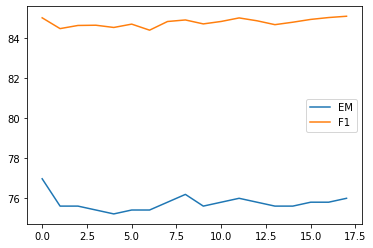

In [69]:
plt.plot([entry['exact_match'] for entry in ewc_history], label='EM')
plt.plot([entry['f1'] for entry in ewc_history], label='F1')
plt.legend()

In [74]:
model.eval()
sentence = "paraphrase: From the merger of the Four Rivers Council and the Audubon Council , the Shawnee Trails Council was born."

encoding = tokenizer.encode_plus(sentence,pad_to_max_length=True, return_tensors="pt")
input_ids, attention_masks = encoding["input_ids"].to(device), encoding["attention_mask"].to(device)

with torch.no_grad():
    beam_outputs = model.generate(
        input_ids=input_ids, attention_mask=attention_masks,
        do_sample=True,
        max_length=256,
        top_k=120,
        top_p=0.98,
        early_stopping=True,
        num_return_sequences=10
    )
    print ("\nOriginal:")
    print (sentence)
    print ("\n")
    print ("Paraphrases:")
    final_outputs =[]
    for beam_output in beam_outputs:
        sent = tokenizer.decode(beam_output, skip_special_tokens=True,clean_up_tokenization_spaces=True)
        if sent.lower() != sentence.lower() and sent not in final_outputs:
            final_outputs.append(sent)

    for i, final_output in enumerate(final_outputs):
        print("{}: {}".format(i, final_output))


Original:
paraphrase: From the merger of the Four Rivers Council and the Audubon Council , the Shawnee Trails Council was born.


Paraphrases:
0: From the merger of Four Rivers Council and Audubon Council, Shawnee Trails Council was established.
1: From the merger of Four Rivers Council and Audubon Council, Shawnee Trails Council was born.
2: From the merger between the four rivers Council and the Audubon Council, erworbene was the Shawnee Trails Council.
3: From the merger of the Four Rivers Council and the Audubon Council, the Shawnee Trails Council was born.
4: The Shawnee Trails Council was born from the merger of the Council of Four Rivers and the Adubon Council.
5: A merger between the Shawnee Trails Council and Audubon Council led to the emergence of Shawnee Trails Council.
6: From the merger of the four river tribe and the Audubon tribes, Shawnee trail tribes were born.
7: From the merger of Four Rivers and Audubon Council, Shawnee Trails Council created.
8: The Shawnee Trails